In [2]:
import pinocchio
import numpy as np
import math

## ESTIMATE FORCE -- OR -- EXTERNAL FORCE OBSERVER
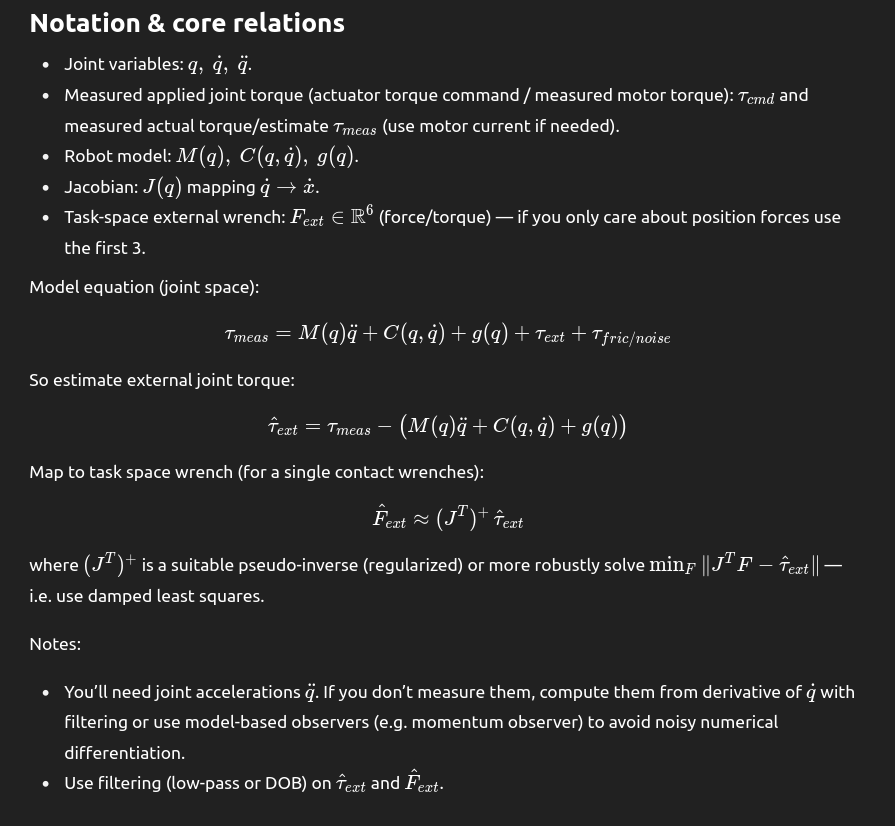

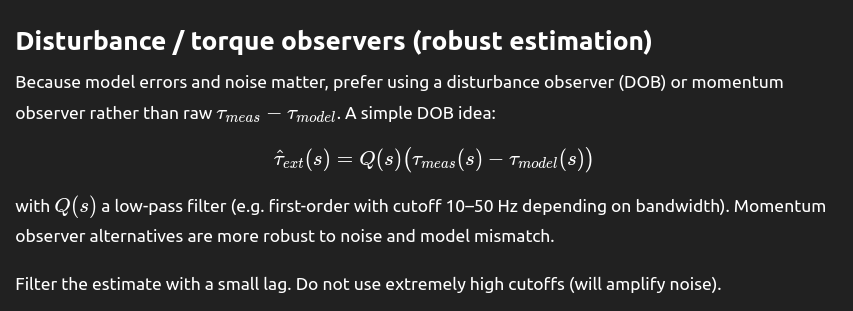

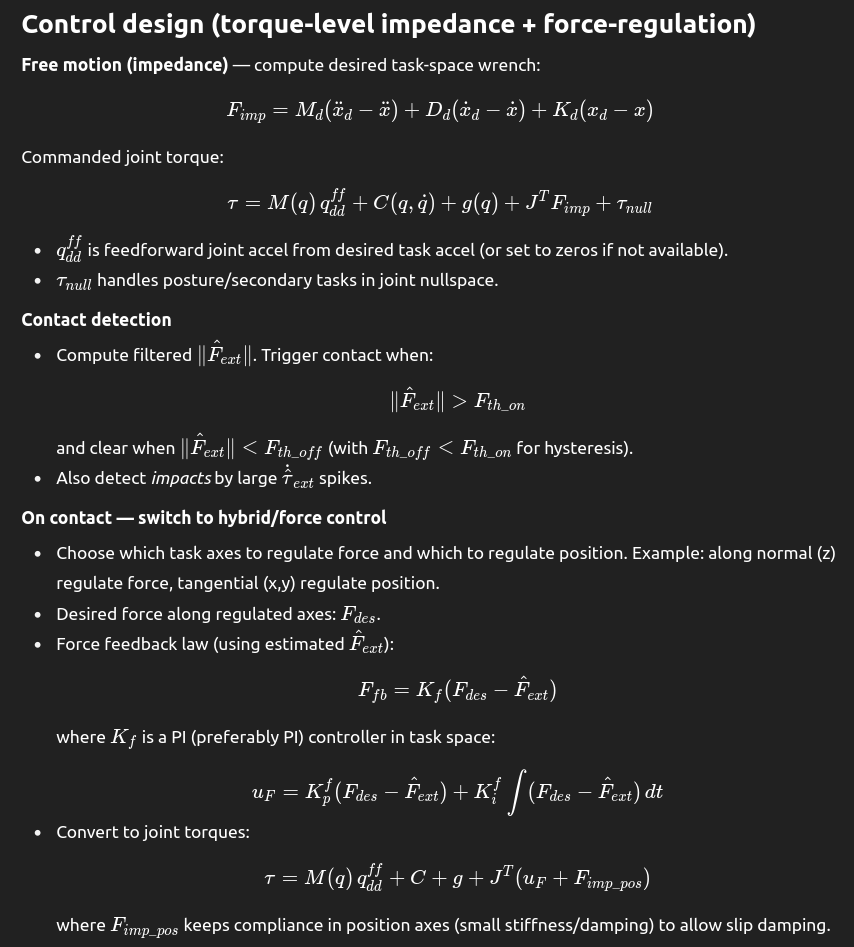

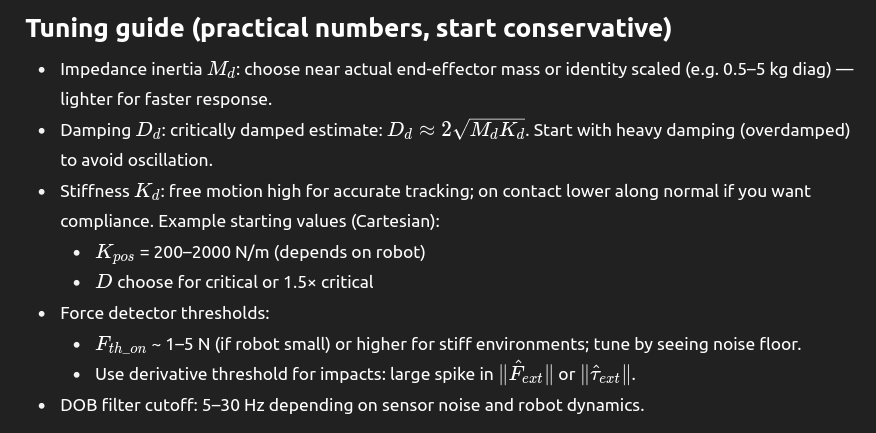

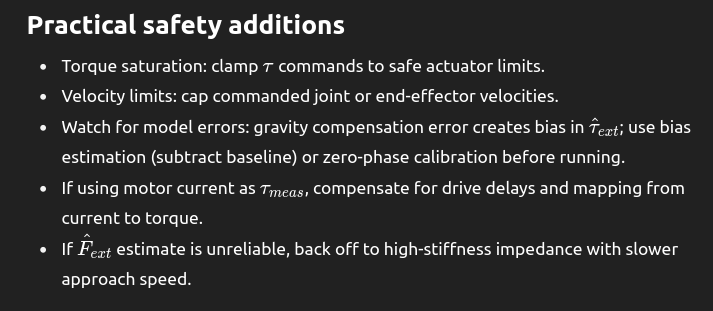

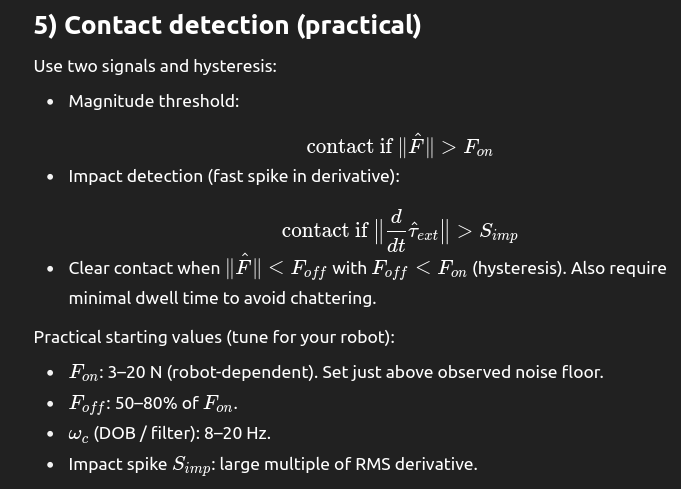

## FOLLOWING STRAIGHT LINE
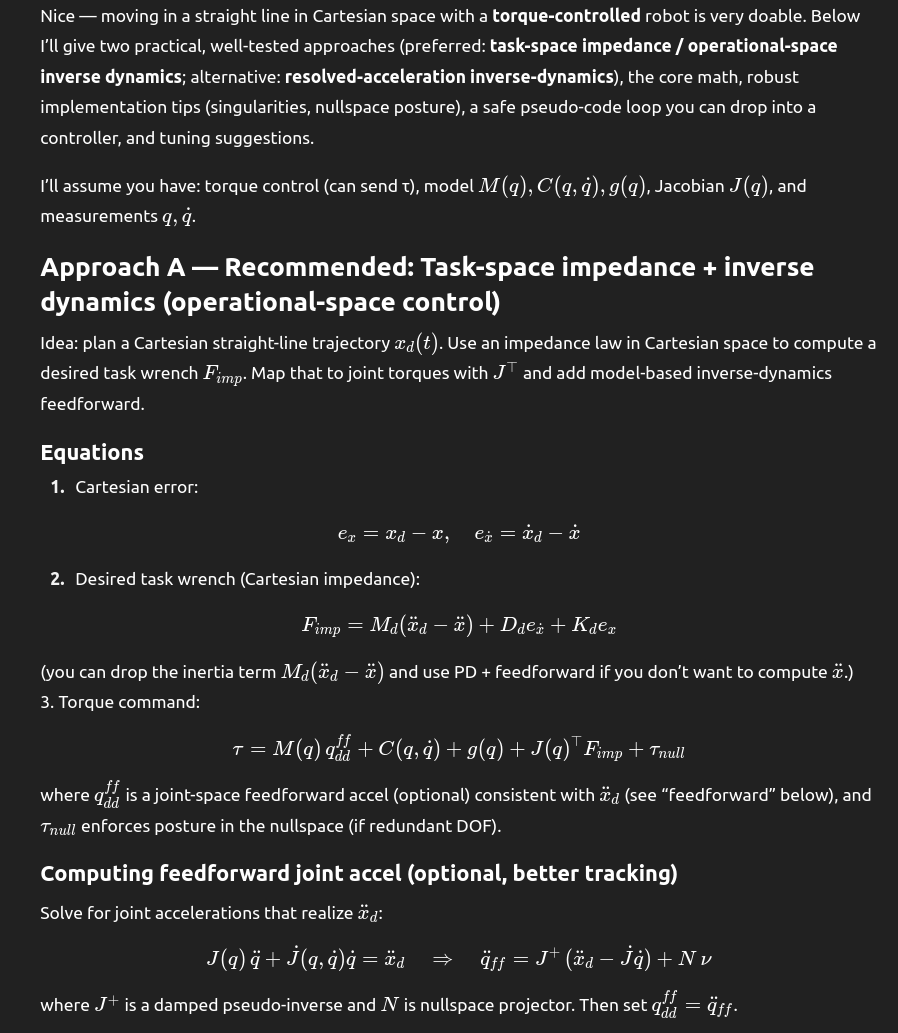

## CARLOS STRATEGY ONE

1. Contact observer, if force detected, lower P & D gains
2. Force sensor will make things so much easier

In [4]:
#model_amir = pinocchio.buildModelFromUrdf("/home/carlos/reach_bravo_7_ws/src/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
model_amir = pinocchio.buildModelFromUrdf("/home/medusa/bravo7_compliance/reach-bravo-7/bpl_bravo_description/urdf/bravo_7_amir_2.urdf")
data_amir = model_amir.createData()
tool_link = "EE"

In [5]:
t = 0
for i in model_amir.frames:
    print(i.name)
    print(t)
    t += 1

universe
0
DH-FRAME-0
1
DH-JOINT-0-1
2
DH-FRAME-0-1
3
DH-JOINT-0-2
4
DH-FRAME-1
5
BRAVO_AXIS_G
6
DH-FRAME-1-1
7
DH-JOINT-1-1
8
DH-FRAME-1-2
9
DH-JOINT-1-2
10
DH-FRAME-2
11
BRAVO_AXIS_F
12
DH-FRAME-2-1
13
DH-JOINT-2-1
14
DH-FRAME-2-2
15
DH-JOINT-2-2
16
DH-FRAME-3
17
BRAVO_AXIS_E
18
DH-FRAME-3-1
19
DH-JOINT-3-1
20
DH-FRAME-3-2
21
DH-JOINT-3-2
22
DH-FRAME-4
23
BRAVO_AXIS_D
24
DH-FRAME-4-1
25
DH-JOINT-4-1
26
DH-FRAME-4-2
27
DH-JOINT4-2
28
DH-FRAME-5
29
BRAVO_AXIS_C
30
DH-FRAME-5-1
31
DH-JOINT-5-1
32
DH-FRAME-5-2
33
DH-JOINT-5-2
34
DH-FRAME-6
35
BRAVO_AXIS_B
36
DH-FRAME-6-1
37
DH-JOINT-6-1
38
DH-FRAME-6-2
39
DH-JOINT-7
40
DH-FRAME-7
41
EE-JOINT
42
EE
43
LINK-6-JOINT
44
LINK-6
45
LINK-5-JOINT
46
LINK-5
47
LINK-4-JOINT
48
LINK-4
49
LINK-3-JOINT
50
LINK-3
51
LINK-2-JOINT
52
LINK-2
53
LINK-1-JOINT
54
LINK-1
55
LINK-0-JOINT
56
LINK-0
57


In [6]:
t = 0
for i in model_amir.frames:
    if (i.name == tool_link):
        print("Frame id of the tool link:", i)
        break

Frame id of the tool link: Frame name: EE paired to (parent joint/ parent frame)(6/42)
with relative placement wrt parent joint:
  R =
           1            0            0
           0           -1 -1.26536e-05
           0  1.26536e-05           -1
  p =        0        0 -0.22416
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0



In [7]:
home = np.array([0.323, 2.708, 0.5045, 1.9917, 1.6112, 0.2304])

In [8]:
J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, 43)
J

array([[ 5.59550414e-02, -2.66022360e-01, -1.91435550e-01,
        -6.00884055e-02,  2.18236659e-01,  0.00000000e+00],
       [-3.48385462e-01, -1.06435720e-01,  1.52048014e-01,
         2.56176256e-01,  5.11910054e-02,  0.00000000e+00],
       [ 1.99054946e-01, -3.06641844e-02,  7.97754489e-02,
         2.74613618e-06, -4.07993523e-02, -0.00000000e+00],
       [ 9.86243687e-01,  5.74038325e-02,  5.74038325e-02,
        -9.72781961e-01, -2.28366972e-01,  0.00000000e+00],
       [ 1.64905629e-01, -4.06213464e-01, -4.06213464e-01,
        -2.28174176e-01,  9.73575126e-01,  1.26535898e-05],
       [ 1.13808655e-02,  9.11973367e-01,  9.11973367e-01,
        -4.03955685e-02,  5.99242538e-06, -1.00000000e+00]])

In [9]:
# Compute pseudoinverse
J_pinv = np.linalg.pinv(J)
Desired_force = np.array([0, 0, 10, 0, 0, 0])  # Desired for in z of 25 N
Torque = np.matmul(J_pinv, Desired_force)
Torque

array([42.93579688, -8.21750379, 18.66109276, 42.49267324,  7.04372715,
        8.29644804])

In [10]:
np.matmul(J, Torque)  # Check if we get back the desired force

array([ 4.44089210e-15, -6.99440506e-15,  1.00000000e+01,  6.66133815e-15,
        8.88178420e-15,  1.42108547e-14])

In [11]:
cond_num = np.linalg.cond(J_pinv)
cond_num

np.float64(15.939745743854026)

In [12]:
pinocchio.rnea(model_amir, data_amir, home, np.zeros(6), np.zeros(6))

array([-3.18735094e-05,  1.00238449e+01,  3.52623230e+00,  1.83892639e-01,
       -1.71705554e+00,  0.00000000e+00])

In [13]:
M_joint_space = pinocchio.crba(model_amir, data_amir, home)
M_joint_space = (M_joint_space + M_joint_space.T) / 2.0            # CRBA can give slight asymmetry -> symmetrize
print("Joint-space mass matrix M(q):")
print(M_joint_space)

Joint-space mass matrix M(q):
[[ 3.46866784e-01  2.28480691e-02 -5.07668207e-02 -7.01790894e-02
  -1.80766761e-02  3.18152494e-06]
 [ 2.28480691e-02  3.88890737e-01  1.55895861e-02 -1.53121738e-02
  -4.05652043e-02 -9.43442899e-04]
 [-5.07668207e-02  1.55895861e-02  1.44153659e-01  5.26938884e-02
  -2.55936564e-02 -9.43442899e-04]
 [-7.01790894e-02 -1.53121738e-02  5.26938884e-02  4.20472073e-02
  -6.78357254e-05  2.69865210e-05]
 [-1.80766761e-02 -4.05652043e-02 -2.55936564e-02 -6.78357254e-05
   2.52991382e-02 -2.44538122e-06]
 [ 3.18152494e-06 -9.43442899e-04 -9.43442899e-04  2.69865210e-05
  -2.44538122e-06  1.03500000e-03]]


In [14]:
frame_name = "EE"  # replace with a valid frame name from your URDF
frame_id = model_amir.getFrameId(frame_name)

# World placement of frame
pinocchio.forwardKinematics(model_amir, data_amir, home)
pinocchio.updateFramePlacements(model_amir, data_amir)

# Get Jacobian in LOCAL frame (6xnv)
J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, frame_id, pinocchio.ReferenceFrame.LOCAL)

print("Jacobian J for frame", frame_name)
print(J)

Jacobian J for frame EE
[[ 5.59550414e-02 -2.66022360e-01 -1.91435550e-01 -6.00884055e-02
   2.18236659e-01  0.00000000e+00]
 [-3.48385462e-01 -1.06435720e-01  1.52048014e-01  2.56176256e-01
   5.11910054e-02  0.00000000e+00]
 [ 1.99054946e-01 -3.06641844e-02  7.97754489e-02  2.74613618e-06
  -4.07993523e-02 -0.00000000e+00]
 [ 9.86243687e-01  5.74038325e-02  5.74038325e-02 -9.72781961e-01
  -2.28366972e-01  0.00000000e+00]
 [ 1.64905629e-01 -4.06213464e-01 -4.06213464e-01 -2.28174176e-01
   9.73575126e-01  1.26535898e-05]
 [ 1.13808655e-02  9.11973367e-01  9.11973367e-01 -4.03955685e-02
   5.99242538e-06 -1.00000000e+00]]


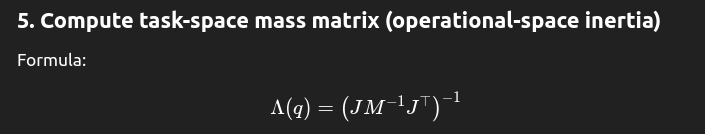

In [15]:
Minv = np.linalg.inv(M_joint_space)
A = J @ Minv @ J.T

# Robust inverse (pseudo-inverse fallback if needed)
if np.linalg.cond(A) < 1e12:
    Lambda = np.linalg.inv(A)
else:
    Lambda = np.linalg.pinv(A)

print("Task-space mass matrix Λ:")
print(Lambda)

Task-space mass matrix Λ:
[[ 7.14841769e+00  2.45902668e+00  5.92082308e-01  5.88837343e-01
  -1.39273668e+00 -1.76231186e-05]
 [ 2.45902668e+00  4.68635971e+00 -3.24308646e-01  9.20338455e-01
  -5.53936234e-01 -7.00928188e-06]
 [ 5.92082308e-01 -3.24308646e-01  5.15930764e+00 -1.09481875e-01
  -1.67219645e-03 -2.11592880e-08]
 [ 5.88837343e-01  9.20338455e-01 -1.09481875e-01  2.02513369e-01
  -1.33339713e-01 -1.66872260e-05]
 [-1.39273668e+00 -5.53936234e-01 -1.67219645e-03 -1.33339713e-01
   2.92795339e-01  2.69181565e-06]
 [-1.76231186e-05 -7.00928188e-06 -2.11592880e-08 -1.66872260e-05
   2.69181565e-06  1.03500002e-03]]


In [16]:
model_amir.nv

6

In [17]:
q_vel = np.array([3, 5.2, 0.5, 0.2, 1.9, 0.2])

In [18]:
q_vel_t = q_vel.transpose()

In [19]:
q = np.array(home, dtype=np.float64).reshape(model_amir.nq)
v = np.zeros(model_amir.nv, dtype=np.float64)
pinocchio.computeCoriolisMatrix(model_amir, data_amir, q, q_vel)
C = data_amir.C


In [20]:
T = M_joint_space - 2*C

In [21]:
result = np.matmul(q_vel_t, np.matmul(T, q_vel)) # In theory this should be zero
result

np.float64(17.76967963775897)

In [22]:
J_pinv @ v

array([0., 0., 0., 0., 0., 0.])

In [23]:
# Yoshikawa manipulability
def yoshikawa_manipulability(J):
    return math.sqrt(np.linalg.det(J @ J.T))

def directional_manipulability(J, v):
    J_pinv = np.linalg.pinv(J)
    aux = J_pinv @ v
    return 1/np.linalg.norm(aux)


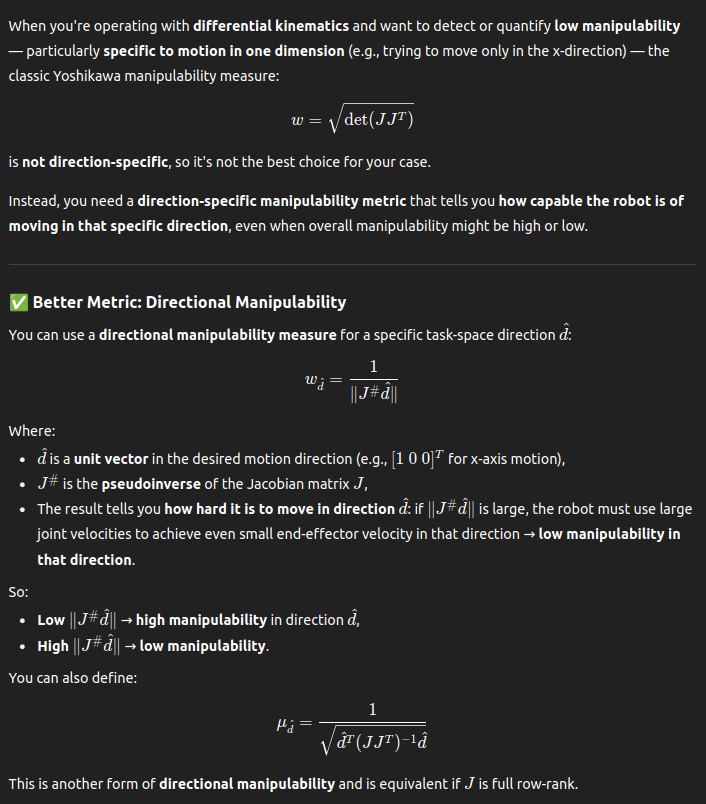

In [24]:
yoshikawa_manipulability(J)

0.008856525261177445

In [25]:
cond_num = np.linalg.cond(J)
cond_num

np.float64(15.93974574385405)

In [8]:
q = np.array(home, dtype=np.float64).reshape(model_amir.nq)
v = np.zeros(model_amir.nv, dtype=np.float64)
pinocchio.computeCoriolisMatrix(model_amir, data_amir, q, q_vel)
C = data_amir.C


NameError: name 'home' is not defined

In [35]:
import pinocchio
print(pinocchio.__version__) 

3.7.0


## Derivative Jacobian (Numerical and Analytical method)

In [ ]:

q_vel = np.array([0.3, 0.2, 0.5, 0.2, 0.7, 0.2])
# Compute forward kinematics and derivatives
pinocchio.forwardKinematics(model_amir, data_amir, home, q_vel)
pinocchio.computeForwardKinematicsDerivatives(model_amir, data_amir, home, q_vel, np.zeros(model_amir.nv))

# Get frame Jacobian
J = pinocchio.computeFrameJacobian(model_amir, data_amir, home, frame_id, pinocchio.LOCAL)

# Approximate dJ/dt (requires custom implementation or numerical method)
# Note: Analytical dJ/dt is complex and depends on the robot's dynamics
# Fallback to numerical method if analytical form is unavailable
dt = 1e-6
q2 = q1 + q_vel * dt
pinocchio.forwardKinematics(model_amir, data_amir, q2)
J2 = pinocchio.computeFrameJacobian(model_amir, data_amir, q2, frame_id, pinocchio.LOCAL)
dJ_numerical_1 = (J2 - J) / dt
dJ_analytical_1 = pinocchio.getFrameJacobianTimeVariation(model_amir, data_amir, frame_id, pinocchio.ReferenceFrame.LOCAL)

print("Approximated NUMERICAL dJ/dt:\n", dJ_numerical_1)
print("Approximated ANALYTICAL dJ/dt:\n", dJ_analytical_1)
error = np.linalg.norm(dJ_numerical_1 - dJ_analytical_1)
print("Difference between numerical and analytical dJ:", error)

Approximated dJ/dt:
 [[-2.20641509e-01 -1.66454614e-01 -1.50167747e-01 -4.32719538e-02
  -1.02381022e-02  0.00000000e+00]
 [-9.18444018e-02  1.16353761e-01  6.18913363e-02 -4.59711920e-02
   4.36473308e-02  0.00000000e+00]
 [ 5.13989779e-02 -1.22138125e-01 -5.66854988e-03 -2.20609021e-07
   5.52294321e-07  0.00000000e+00]
 [ 6.69591641e-02 -4.95373804e-01 -4.95373804e-01  7.31639213e-02
  -1.94715021e-01  0.00000000e+00]
 [-4.27963197e-01 -3.11271251e-01 -3.11271251e-01 -1.88094736e-01
  -4.56734138e-02  0.00000000e+00]
 [ 3.98503463e-01 -1.07466291e-01 -1.07466291e-01 -6.99431088e-01
  -5.77932643e-07  0.00000000e+00]]
Approximated dJ/dt:
 [[-2.20641617e-01 -1.66454562e-01 -1.50167721e-01 -4.32719803e-02
  -1.02380819e-02  5.55805402e-14]
 [-9.18443178e-02  1.16353887e-01  6.18914875e-02 -4.59711275e-02
   4.36473489e-02 -9.57567359e-16]
 [ 5.13989864e-02 -1.22138148e-01 -5.66860159e-03 -2.34455805e-07
   5.42123696e-07  7.03650122e-18]
 [ 6.69589969e-02 -4.95374022e-01 -4.95374022e-0

## Acceleration-based differential kinematics

$$
\ddot{\mathbf{x}} = \mathbf{J}(\mathbf{q}) \, \ddot{\mathbf{q}} + \dot{\mathbf{J}}(\mathbf{q}, \dot{\mathbf{q}}) \, \dot{\mathbf{q}}
$$


**Given:**  

-  $\mathbf{J}$ : Jacobian  
-  $\dot{\mathbf{J}}$ : Time derivative of the Jacobian  
-  $\dot{\mathbf{q}}$ : Joint velocities  
-  $\ddot{\mathbf{x}}_{\text{desired}}$ : Desired end-effector acceleration  

**Solve:**  
$$
- \mathbf{J} \, \ddot{\mathbf{q}} = \ddot{\mathbf{x}}_{\text{desired}} - \dot{\mathbf{J}} \, \dot{\mathbf{q}} 
$$
**Python code:**
```python
rhs = x_ddot_desired - dJ @ q_dot
q_ddot = np.linalg.pinv(J) @ rhs

In [51]:
x_ddot = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0])  # Desired end-effector acceleration
rhs = x_ddot - dJ_analytical_1 @ q_vel
q_ddot = np.linalg.pinv(J) @ rhs
q_ddot

array([ 1.24438271, -0.82646294,  0.64407387,  0.71754243,  0.30845331,
       -0.27671747])